# nndist_scaling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.ma as ma
import matplotlib.pyplot as plt
from math import erf
from scipy.optimize import curve_fit
from tqdm import tqdm

In [4]:
## functions
def load_IDs(L, seeds):
    Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

    ID = -1*np.ones((len(seeds),len(Ws)))
    
    count = 0
    missing = []
    for seed in seeds:
        try:
            data = np.atleast_2d(np.load("cluster_data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            ID[seed] = np.array([data[i]['ID']*data[i]['rsquared'] for i in range(len(Ws))])
        except:
            missing.append(seed)
            continue
            
    ID = ma.masked_equal(ID, -1)
    print("Loaded {0} out of {1} seeds".format(len(seeds)-len(missing), len(seeds)))
    return ID


def bins_upper(L):
    bins_upper_dict = {8:10,10:20,12:35,14:70}
    return bins_upper_dict[L]

def make_hists(Ws, num_seeds=100, L=8, plot=False):    
    hists = {}
    for i,W in tqdm(enumerate(Ws)):
        histogram = 0
        for seed in range(num_seeds):
            data = np.atleast_2d(np.load("data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]

            h, binedges = np.histogram(data[i]['nndist'], bins=np.linspace(0,bins_upper(L),100))
            histogram += h
        if plot:
            plt.plot(np.linspace(0,bins_upper(L),100)[:-1], histogram/num_seeds, label=W)
        hists[W] = histogram
    return hists

def fit_normal(L, Ws, hists):
    mu = {}
    sigma = {}
    for W in Ws:
        y = hists[W]
        x = np.linspace(0,bins_upper(L),100)[:-1]
        popt, pcov = curve_fit(normal, x,y, maxfev=10000, p0=[5000,4,15])
        mu[W] = popt[2]
        sigma[W] = popt[1]
    return mu, sigma

def logistic(x,a,k, b, x_0):
    return a/(1+np.exp(k*(x-x_0))) +b


@np.vectorize
def Erf(x):
    return erf(x)

def normal(x, a,sigma, mu):
    return a/(sigma*(2*np.pi)**0.5) * np.exp(-.5*((x-mu)/sigma)**2)


def skew_normal(x,A,a, omega,epsilon):
    sqrt_2_pi = (2*np.pi)**.5
    psi = 2/omega * 1/sqrt_2_pi * np.exp(-.5* ((x-epsilon)/omega)**2)
    Psi = 1/2 * (1+Erf(a*(x-epsilon)/(omega*(2)**.5)))
    return  A*psi * Psi


def dydx2(x,y):
    
    dx = xdata[1]-xdata[0]
    dydx = np.gradient(ydata, dx)
    dydx2_ = np.gradient(dydx, dx)
    return dydx2_


In [14]:
data = np.atleast_2d(np.load("cluster_data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(16,0), allow_pickle=True))[0]
print(data[1]['ID'])


IndexError: index 1 is out of bounds for axis 0 with size 1

Loaded 10000 out of 10000 seeds
Loaded 1000 out of 1000 seeds
Loaded 1000 out of 1000 seeds
Loaded 1000 out of 1000 seeds
Loaded 0 out of 32 seeds


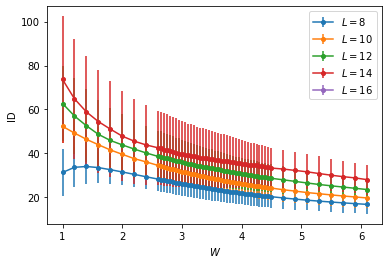

In [6]:
Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

ID8 = load_IDs(8, range(0,10000))
ID10 = load_IDs(10, range(0,1000))
ID12 = load_IDs(12, range(0,1000))
ID14 = load_IDs(14, range(0,1000))
ID16 = load_IDs(16, range(0,32))

In [ ]:
fig, ax = plt.subplots()
for ID, l in zip([ID8, ID10, ID12, ID14, ID16], [8,10,12,14,16]):
    ax.errorbar(Ws, ma.mean(ID,axis=0), yerr=ma.std(ID,axis=0), marker='o', ms=4, label="$L={}$".format(l))

ax.set_xlabel("$W$")
ax.set_ylabel("ID")
ax.legend(fancybox=True)

In [71]:
data = {8:{},10:{},12:{},14:{}}

55it [00:11,  4.71it/s]


In [117]:
for L,num_seeds in zip([8,10,12,14],[100000,10000,5000,1000]):
    data[L]['hists'] = make_hists(Ws, num_seeds=num_seeds, L=L, plot=False)
    data[L]['mu'], data[L]['sigma'] = fit_normal(L, Ws,w data[L]['hists'])

55it [5:28:42, 358.59s/it]
55it [53:11, 58.03s/it]
55it [49:32, 54.04s/it]
55it [11:08, 12.16s/it]


8
[5.06281587 0.7316178  4.0144762  3.34407618]
[8.50156297 3.3019327  5.47819166 1.99024981]
10
[12.7909423   0.76396249  5.21117295  3.18219869]
[14.30323593  3.17416417  4.29437682  2.10441398]
12
[26.64151844  0.87749182  7.02037221  3.25463504]
[23.00206499  2.29451818  3.13018549  2.36608238]
14
[53.18533617  1.00331221  9.11822138  3.39379573]
[37.63715822  1.34686468  2.17762236  2.80578139]


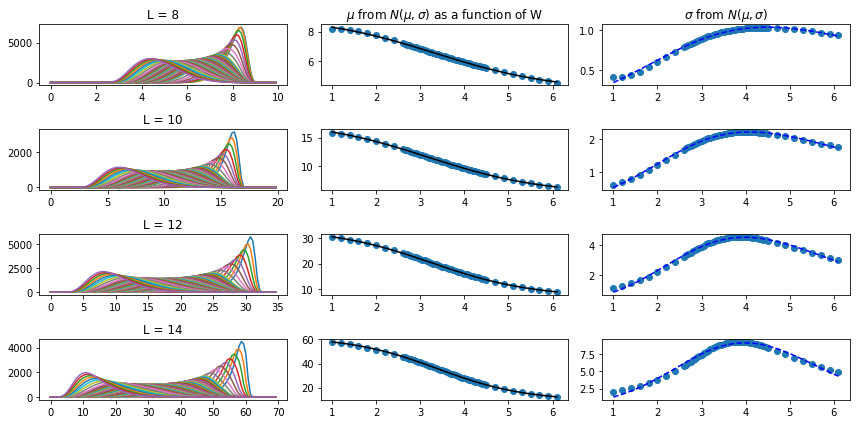

In [118]:
fig, ax = plt.subplots(4,3,figsize=(12,6))

ax[0,1].set_title('$\mu$ from $N(\mu,\sigma)$ as a function of W')
ax[0,2].set_title('$\sigma$ from $N(\mu,\sigma)$')


out = {'logistic': {}, 'skew_normal':{}}
for i, L in enumerate([8,10,12,14]):
    print(L)
    ax[i,0].set_title(f'L = {L}')
    [ax[i,0].plot(np.linspace(0,bins_upper(L),100)[:-1], data[L]['hists'][W]/100) for W in Ws]

    
    ax[i,1].scatter(data[L]['mu'].keys(),data[L]['mu'].values())
    
    try:
        xdata = np.linspace(min(data[L]['mu'].keys()),max(data[L]['mu'].keys()), 1000)
        popt, pcov = curve_fit(logistic, 
                               np.array(list(data[L]['mu'].keys()))[:],
                               np.array(list(data[L]['mu'].values()))[:], 
                               p0=[12.6, .75, 5.,3.9], method='dogbox', maxfev=20000)
        ax[i,1].plot(xdata,logistic(xdata, *popt), c='black')
        print(popt)
        out['logistic'][L] = popt
    except:
        print(L, 'failed logistic')

    
    ax[i,2].scatter(data[L]['sigma'].keys(),data[L]['sigma'].values())

    try:
        xdata = np.linspace(min(data[L]['sigma'].keys()),max(data[L]['sigma'].keys()), 1000)
        popt, pcov = curve_fit(skew_normal, 
                               np.array(list(data[L]['sigma'].keys()))[:],
                               np.array(list(data[L]['sigma'].values()))[:], 
                               p0=[10.,.27,2,3.5], maxfev=20000, )


        ax[i,2].plot(xdata,skew_normal(xdata, *popt), c='b',ls='--', label=popt)
        print(popt)
        out['skew_normal'][L] = popt
    except:
        print(L, 'failed skew normal')
    
plt.tight_layout()

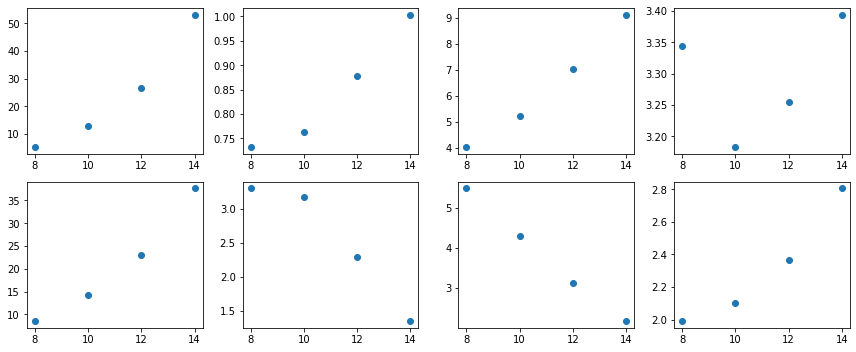

In [121]:
fig, ax = plt.subplots(2,4, figsize=(12,5))
Ls = [8,10,12,14]

def asymptote(x,a,b,c):
    return a/(x-b)+c

for i in range(4):
    ax[0,i].scatter(Ls, [out['logistic'][l][i] for l in Ls])   
    
    ax[1,i].scatter(Ls, [out['skew_normal'][l][i] for l in Ls])
    
'''
popt, pcov = curve_fit(asymptote, 
                               Ls,
                               [out['logistic'][l][3] for l in Ls], 
                               p0=[12.6, .75, 5.], method='dogbox', maxfev=20000)
xdata = np.linspace(min(Ls), max(Ls), 1000)
ax[0,3].plot(xdata, asymptote(xdata, *popt))

popt, pcov = curve_fit(asymptote, 
                               Ls,
                               [out['skew_normal'][l][3] for l in Ls], 
                               p0=[12.6, .75, 5.], method='dogbox', maxfev=20000)
xdata = np.linspace(min(Ls), max(Ls), 1000)
ax[0,3].plot(xdata, asymptote(xdata, *popt))
'''
plt.tight_layout()

In [133]:
skew_normal, logistic

(<function __main__.skew_normal(x, A, a, omega, epsilon)>,
 <function __main__.logistic(x, a, k, b, x_0)>)

In [123]:
np.savez('data/hists_mu_sigma.npz',data)

In [132]:
wuhuu = np.load('data/hists_mu_sigma.npz', allow_pickle=True)
wuhuu[wuhuu.files[0]]

array({8: {'hists': {1.0: array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            2,      2,      0,      2,      8,      4,      8,     20,
           32,     34,     40,     50,    104,    152,    158,    232,
          312,    422,    596,    646,    878,   1120,   1562,   1952,
         2558,   3013,   3975,   5044,   6663,   8374,  10705,  14126,
        18116,  23441,  30961,  40276,  53183,  67902,  88067, 111288,
       140495, 171477, 208057, 248048, 293742, 347063, 407188, 475099,
       548993, 622990, 675696, 691197, 639833, 509976, 325185, 149271,
        43142,   6197,    317,      6,      0,      0,      0,      0,
            0,      0,      0]), 1.2: array([     0,      0,      0,      0,      0,      0,      0,      0,
            0